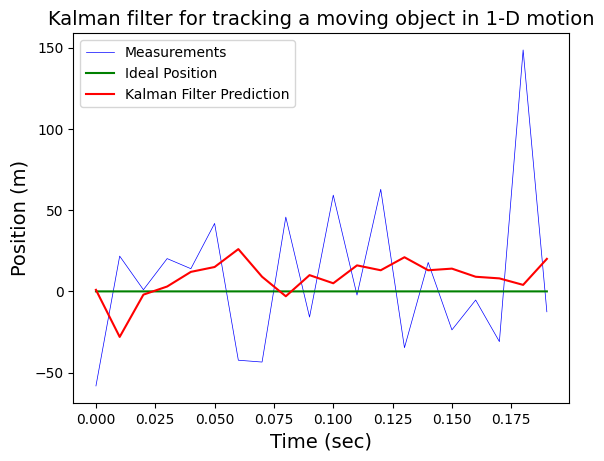

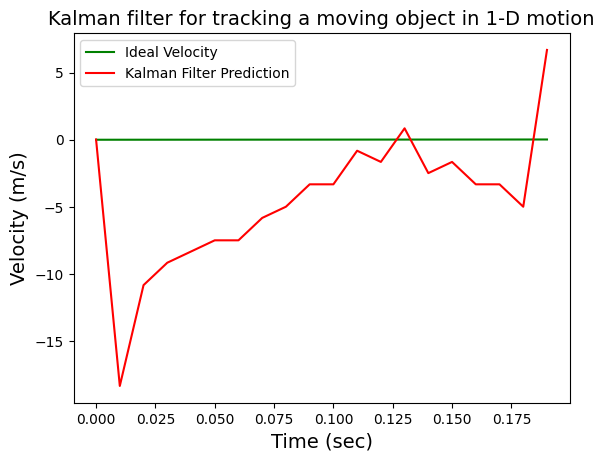

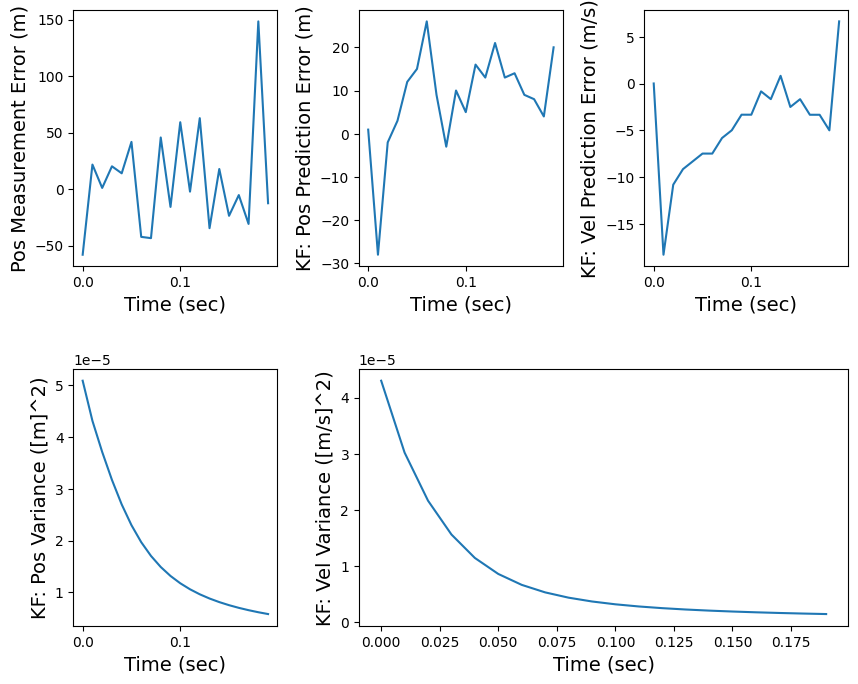

In [13]:
import numpy as np
import matplotlib.pyplot as plt   
import math as m
import numpy as np             

class KalmanFilter(object):
    def __init__(self, dt, i,ef,cn,c1,r1,c2,r2, std_i, std_z):
        self.dt = dt # discrete time step (Unit: sec)
        self.i = i # discrete input (Unit: m/s^2)
        self.ef = ef
        self.cn = cn
        self.c1 = c1
        self.r1 = r1
        self.c2 = c2
        self.r2 = r2
        self.std_i = std_i # standard deviation of the acceleration
        self.std_z= std_z
        # State Transition Matrix : A
        self.A = np.matrix([[1, 0, 0],
                            [0, m.exp(-self.dt/r1*c1), 0 ],
                            [0, 0, m.exp(-self.dt/r2*c2)]])
        
        # Control Input Matrix : B 
        self.B = np.matrix([[(-self.ef*self.dt)/3600*self.cn],
                            [1-(m.exp((-self.dt)/self.r1*self.c1))],
                            [1-(m.exp((-self.dt)/self.r2*self.c2))]])
        
        # Transformation matrix : H
        self.H = np.matrix([[1,1,1]])
        
        
        # Process noise covariance Matrix : Q
        self.Q = np.matrix([[((-self.ef*self.dt)/(3600*self.cn))**2,((self.ef*self.dt)/(3600*self.cn))*(1-m.exp(-self.dt/self.r1*self.c1)),((self.ef*self.dt)/(3600*self.cn))*(1-m.exp(-self.dt/self.r2*self.c2))],
                            [(1-m.exp(-self.dt/self.r1*self.c1))*((-self.ef*self.dt)/(3600*self.cn)) ,(1-m.exp(-self.dt/self.r1*self.c1))**2,(1-m.exp(-self.dt/self.r1*self.c1))*(1-m.exp(-self.dt/self.r2*self.c2))],
                            [(1-m.exp(-self.dt/self.r1*self.c1))*((-self.ef*self.dt)/(3600*self.cn)), (1-m.exp(-self.dt/self.r1*self.c1))*(1-m.exp(-self.dt/self.r2*self.c2)),(1-m.exp(-self.dt/self.r2*self.c2))**2]]) * self.std_i**2
       
        # Measurement noise covariance Matrix : R
        self.R = std_z**2
        self.P = np.eye(self.A.shape[1])*1*10**(-4) # Initialize Error Covariance: P
        self.x = np.matrix([[0.95],[0],[0]]) # Initialize State Vector : x
        
    def PredictUpdate(self):
        # Eq.(1): Prediction Update for state at each time step
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.i)
        # Eq.(2): Calculate Priori Error Covariance: P = A*P*A' + Q
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x
    
    def MeasurementUpdate(self, z):
        # Eq.(3): Measurement Update for compute Kalman Gain: S = H*P*H'+R 
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        # Eq.(3): Kalman Gain: K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  
        # Eq.(4): Calculate Posteriori State Estimate
        self.x = np.round(self.x + np.dot(K, (z - np.dot(self.H, self.x))))  
        # Eq.(5): Calculate Posteriori Error Covariance 
        I = np.eye(self.H.shape[1])
        self.P = (I - ( K* self.H)) * self.P
        return self.P

dt = 0.01 # discrete time step (Unit: sec)
i= 0.1 # constant acceleration (Unit: m/s^2)
ef=0.989
cn=6.8
c1=123.19*10**(-3)
r1=6.75*10**(-3)
c2=4.52*10**(3)
r2=2.57*10**(-3)
std_i=0.005     # the standard deviation of the acceleration (Unit: Amp)
std_z=0.1*std_i   # standard deviation of SOC
std_v = 0.035   # the standard deviation of output voltage-measurement noise (Unit: volt)
t = np.arange(0, 0.2, dt) # discrete time
Ideal_Motion = 0.5*i*(t**2) # generate an Ideal Motion Path
Ideal_Vel = i*t # generate an Ideal Velocity 


# create KalmanFilter object
kf = KalmanFilter(dt,i,ef,cn,c1,r1,c2,r2,std_i,std_z) 

predictions = []  # initialize empty prediction update
predictPos = []   # initialize Position prediction
predictVel = []   # initialize Velocity prediction
measurements = [] # initialize empty measurement update
PosMeasurements = [] # initialize Position measurement 
ErrorCovPos = []  # intitialize empty priori error covariance of Position
ErrorCovVel = []  # intitialize empty priori error covariance of Velocity

i=0
for x in Ideal_Motion:
    # Mesurement at each time step
    z = (kf.H * x) + np.random.normal(0, 40)
    PosMeasurements.append(z.item(0))
    # Kalman Filter: Prediction Update
    predictions.append(kf.PredictUpdate())
    predictPos.append(predictions[i].item((0)))
    predictVel.append(predictions[i].item((1)))
    # Kalman Filter: Measurement Update
    measurements.append(kf.MeasurementUpdate(z.item(0)))
    ErrorCovPos.append(measurements[i].item(0,0))
    ErrorCovVel.append(measurements[i].item(1,1))
    i=i+1

MeasurementError = PosMeasurements - np.array(Ideal_Motion) 
KFPosPredictError = predictPos - np.array(Ideal_Motion)
KFVelPredictError = predictVel - np.array(Ideal_Vel) 
  
plt.figure(1)
plt.title('Kalman filter for tracking a moving object in 1-D motion', fontsize=14)
plt.plot(t, PosMeasurements, label='Measurements', color='b', linewidth=0.5)
plt.plot(t, np.array(Ideal_Motion), label='Ideal Position', color='g', linewidth=1.5)
plt.plot(t, predictPos, label='Kalman Filter Prediction', color='r', linewidth=1.5)
plt.xlabel('Time (sec)', fontsize=14)
plt.ylabel('Position (m)', fontsize=14)
plt.legend()

plt.figure(2)
plt.title('Kalman filter for tracking a moving object in 1-D motion', fontsize=14)
plt.plot(t, np.array(Ideal_Vel), label='Ideal Velocity', color='g', linewidth=1.5)
plt.plot(t, predictVel, label='Kalman Filter Prediction', color='r', linewidth=1.5)
plt.xlabel('Time (sec)', fontsize=14)
plt.ylabel('Velocity (m/s)', fontsize=14)
plt.legend()

plt.figure(3, figsize=(10, 8))
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.4)
# Fig3 Subplot 1
plt.subplot(grid[0, 0])
plt.plot(t, MeasurementError)
plt.xlabel('Time (sec)', fontsize=14)
plt.ylabel('Pos Measurement Error (m)', fontsize=14)
# Fig3 Subplot 2
plt.subplot(grid[0, 1])
plt.plot(t, KFPosPredictError)
plt.xlabel('Time (sec)', fontsize=14)
plt.ylabel('KF: Pos Prediction Error (m)', fontsize=14)
# Fig3 Subplot 3
plt.subplot(grid[0, 2])
plt.plot(t, KFVelPredictError)
plt.xlabel('Time (sec)', fontsize=14)
plt.ylabel('KF: Vel Prediction Error (m/s)', fontsize=14)
# Fig3 Subplot 4
plt.subplot(grid[1, 0])
plt.plot(t, ErrorCovPos)
plt.xlabel('Time (sec)', fontsize=14)
plt.ylabel('KF: Pos Variance ([m]^2)', fontsize=14)
# Fig3 Subplot 5
plt.subplot(grid[1, 1:])
plt.plot(t, ErrorCovVel)
plt.xlabel('Time (sec)', fontsize=14)
plt.ylabel('KF: Vel Variance ([m/s]^2)', fontsize=14)
plt.show()